# Exploring & Testing Use of NURBS in DIC
## Sam Potter
## Current: 2/18/19

## Path and Imports

In [1]:
# bootstrap $PATH
import sys
import os
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
import warnings
from dic import nurbs
from dic import fileIO
from dic import numerics
from dic import analysis
from dic import image_processing
from dic import visualize
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from geomdl import BSpline as bs
from geomdl import utilities as gutil
from geomdl import helpers
import scipy.optimize as sciopt
import scipy.signal as sig

## Magics

In [2]:
%matplotlib inline

### Read in ref image file

In [3]:
# Read
# Hard code absolute paths for now. Fix later'
dic_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DOA_cropped_gray_pad_0.tiff'
dic_name = '/workspace/stpotter/git/bitbucket/dic/data/DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = '/workspace/stpotter/git/bitbucket/dic/data/DOSA_cropped_gray_pad_0.tiff'
def_image = cv2.imread(dic_name, -1)  # Read in image 'as is'
#def_image = def_image.astype('uint8')

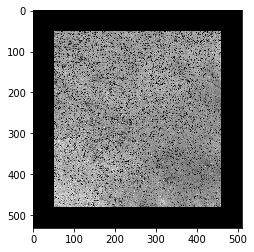

In [4]:
# Display
plt.imshow(def_image, cmap='gray')

## Deform Ref Image

In [5]:
# Translate image
dx = 0.0
dy = 0.0
f11 = 1.01
f12 = 0.0
f21 = 0.0
f22 = 1.0
f = np.array([[f11, f12],
             [f21, f22]])
finv = np.linalg.inv(f)
f11i = finv[0, 0]
f12i = finv[0, 1]
f21i = finv[1, 0]
f22i = finv[1, 1]
transx = np.array([[f11i, f12i, dx],
                   [f21i, f22i, dy]])
ref_image = image_processing.im_warp(def_image, transx)

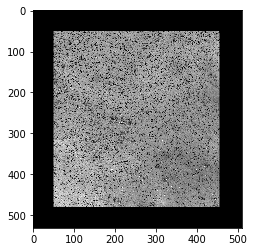

In [6]:
# Display
plt.imshow(ref_image, cmap='gray')

## Manually Specify Region of Interest

In [7]:
# Format: [column index for start of X, column index for end of X, row index for start of Y, row index for end of Y]
subregion_indices = np.array([125, 375, 125, 375])

## Setup reference mesh

In [8]:
# Control Points
rowmin = subregion_indices[-2:].min()
rowmax = subregion_indices[-2:].max()
colmin = subregion_indices[:2].min()
colmax = subregion_indices[:2].max()
x = np.linspace(colmin, colmax, 4)
y = np.linspace(rowmin, rowmax, 4)
coords = np.zeros((len(x) * len(y), 2))
k = 0
for i in range(0, len(x)):
    for j in range(0, len(y)):
        coords[k, :] = np.array([x[i], y[j]])
        k += 1

In [9]:
# Surface
ref_surf = bs.Surface()

ref_surf.degree_u = 3
ref_surf.degree_v = 3

num_ctrlpts = np.sqrt(len(coords)).astype('int')

ref_surf.set_ctrlpts(coords.tolist(), num_ctrlpts, num_ctrlpts)

ref_surf.knotvector_u = gutil.generate_knot_vector(ref_surf.degree_u, num_ctrlpts)
ref_surf.knotvector_v = gutil.generate_knot_vector(ref_surf.degree_v, num_ctrlpts)

ref_surf.delta = 0.01

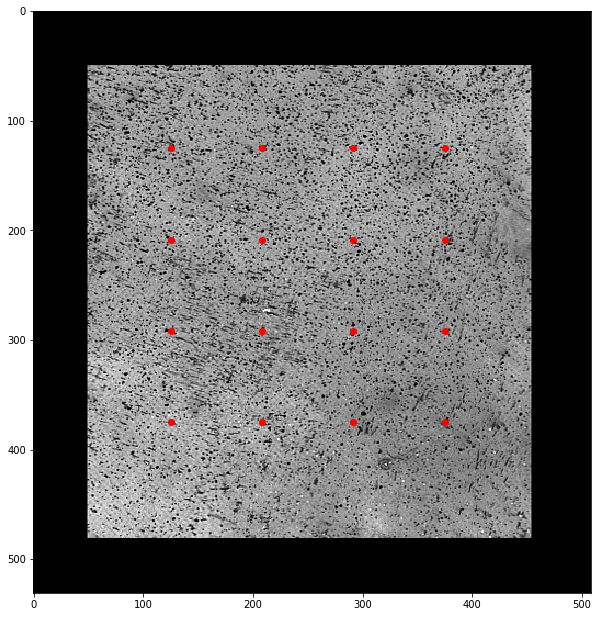

In [10]:
# Plot the mesh nodes on the original image
# Would be nice to be able to visualize full mesh
x = coords[:, 0]
y = coords[:, 1]
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(ref_image, cmap='gray')
ax.plot(x, y, 'o', color='red')
plt.show()

## Test Synthetically Deforming Ctrlpts

In [11]:
F = np.array([[f11, f12],
             [f21, f22]])

coords_new = np.zeros((len(coords), 2))

for i in range(len(coords_new)):
    coords_new[i, :] = np.matmul(F, coords[i, :]) + np.array([dx, dy])

In [12]:
# Set up new surface
disp_surf = bs.Surface()

disp_surf.degree_u = 3
disp_surf.degree_v = 3

num_ctrlpts = np.sqrt(len(coords_new)).astype('int')

disp_surf.set_ctrlpts(coords_new.tolist(), num_ctrlpts, num_ctrlpts)

disp_surf.knotvector_u = gutil.generate_knot_vector(disp_surf.degree_u, num_ctrlpts)
disp_surf.knotvector_v = gutil.generate_knot_vector(disp_surf.degree_v, num_ctrlpts)

disp_surf.delta = 0.01

In [13]:
# Compute control point displacements
coords_disp = coords_new - coords
synth_disp = np.ndarray.flatten(coords_disp)

# Compute mesh_znssd
analysis.mesh_znssd(ref_image, def_image, ref_surf, coords_disp)

145.98701144805173

In [14]:
coords_new

array([[126.25      , 125.        ],
       [126.25      , 208.33333333],
       [126.25      , 291.66666667],
       [126.25      , 375.        ],
       [210.41666667, 125.        ],
       [210.41666667, 208.33333333],
       [210.41666667, 291.66666667],
       [210.41666667, 375.        ],
       [294.58333333, 125.        ],
       [294.58333333, 208.33333333],
       [294.58333333, 291.66666667],
       [294.58333333, 375.        ],
       [378.75      , 125.        ],
       [378.75      , 208.33333333],
       [378.75      , 291.66666667],
       [378.75      , 375.        ]])

## Visualize synthetic displacement results

In [15]:
# Set up new surface
disp_surf = bs.Surface()

disp_surf.degree_u = 3
disp_surf.degree_v = 3

disp_surf.set_ctrlpts(coords_disp.tolist(), num_ctrlpts, num_ctrlpts)

disp_surf.knotvector_u = gutil.generate_knot_vector(disp_surf.degree_u, num_ctrlpts)
disp_surf.knotvector_v = gutil.generate_knot_vector(disp_surf.degree_v, num_ctrlpts)

disp_surf.delta = 0.01

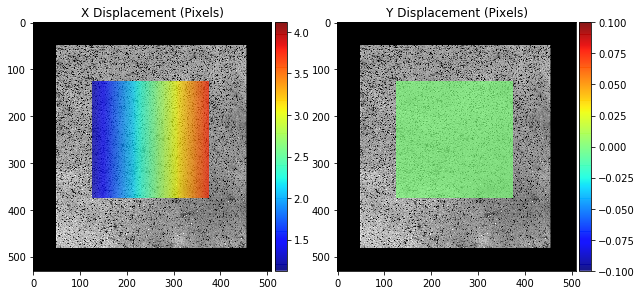

In [16]:
visualize.viz_displacement(ref_image, disp_surf, rowmin, rowmax, colmin, colmax, 'foo', save=False)

## Visualize synthetic deformation results

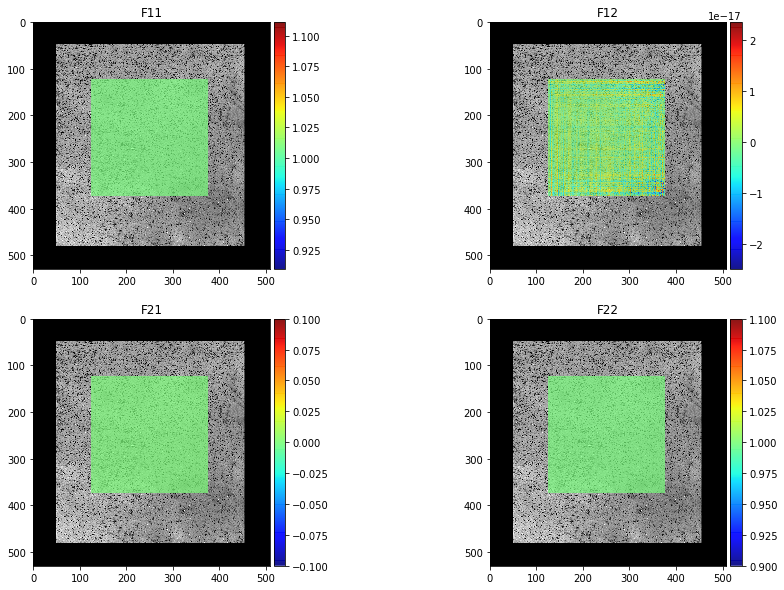

In [17]:
visualize.viz_deformation(ref_image, ref_surf, rowmin, rowmax, colmin, colmax, coords_disp, 'bar', save=False)

In [18]:
print('Deformation gradient at center of ROI from synthetic data')
print(visualize.def_grad(ref_surf, 0.5, 0.5, coords_disp))

Deformation gradient at center of ROI from synthetic data
[[1.01 0.  ]
 [0.   1.  ]]


## Compute deformation via optimization

In [ ]:
# Pack necessary arguments into a tuple
arg_tup = (ref_image, def_image, ref_surf)

int_disp_vec = analysis.rigid_guess(ref_image, def_image, rowmin, rowmax, colmin, colmax, len(coords))

# compute mesh znssd one time and exit if its low enough

residual = analysis.scipy_minfun(int_disp_vec, *arg_tup)

if residual > 1e-6:
    print('Begin minimization')
    result = sciopt.minimize(analysis.scipy_minfun, int_disp_vec, args=arg_tup, method='L-BFGS-B', jac='2-point', bounds=None, options={'maxiter': 5, 'disp': True})

print('Actual Rigid X Displacement: {}'.format(dx))
print('Actual Rigid Y Displacement: {}'.format(dy))
print('Mesh Details: {} by {}'.format(num_ctrlpts, num_ctrlpts))
print('Initial Guess -  X Displacement: {}'.format(int_disp_vec[0]))
print('Initial Guess - Y Displacement: {}'.format(int_disp_vec[1]))

if residual > 1e-6:
    print('residual')
    print(result.fun)
    print('final control point displacements')
    print(result.x)
    coords_disp = np.column_stack((result.x[::2], result.x[1::2]))
else:
    print('residual')
    print(residual)
    print('final control point displacement')
    print(int_disp_vec)
    coords_disp = np.column_stack((int_disp_vec[::2], int_disp_vec[1::2]))

Begin minimization


## Visualize minimization displacement results

In [ ]:
# Set up new surface
disp_surf = bs.Surface()

disp_surf.degree_u = 3
disp_surf.degree_v = 3

disp_surf.set_ctrlpts(coords_disp.tolist(), num_ctrlpts, num_ctrlpts)

disp_surf.knotvector_u = gutil.generate_knot_vector(disp_surf.degree_u, num_ctrlpts)
disp_surf.knotvector_v = gutil.generate_knot_vector(disp_surf.degree_v, num_ctrlpts)

disp_surf.delta = 0.01

In [ ]:
visualize.viz_displacement(ref_image, disp_surf, rowmin, rowmax, colmin, colmax, 'foo', save=False)

## Visualize minimization deformation results

In [ ]:
visualize.viz_deformation(ref_image, ref_surf, rowmin, rowmax, colmin, colmax, coords_disp, 'bar', save=False)

In [ ]:
print('Deformation gradient at center of ROI from minimization data')
print(visualize.def_grad(ref_surf, 0.5, 0.5, coords_disp))